# Data Preparation

In this sectiono we load in and prepare the data for our machine learning.

In [1]:
# !pip install scipy
# !pip install pandas
# !pip install scikit-learn

In [2]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# # Anything above 2.10 is not supported on the GPU on Windows Native
# !pip install "tensorflow<2.11"


<!-- !pip list
!pip install -q seaborn -->

In [1]:
import os
import scipy.io as sio
import pandas as pd
from scipy.io import loadmat
import datetime
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

np.set_printoptions(precision=3, suppress=True)

## Ingesting the data

The following data is from a Nasa dataset with n refferring to the iteration number of the dataset used. 
Temperature is in celcius
Voltage is in volts
Current is in Amps

In [2]:
n = 'B0005'
df = pd.read_csv('data_frames/' + 'NASA_cycle_dataset_' + n +'.csv',
                 parse_dates = ["datetime"]).drop(["Unnamed: 0"], axis = 1)
df.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,NaN
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,NaN
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,NaN
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,NaN
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,NaN


In [3]:
df.shape

(591458, 10)

## Beginning Data engineering

In the Below cells we are attempting to fill in the missing values. A brief look at the dataset showed that each cycle potentially had a capacity for at least one of its rows. 

First we test that theory:

In [4]:
capacity_counts = pd.DataFrame(df.groupby('cycle')['capacity'].nunique())
zero_capacity_rows = capacity_counts[capacity_counts['capacity'] != 1]
# capacity_counts
zero_capacity_rows

,capacity
cycle,
169,0
170,0


In [5]:
cap_std = df['capacity'].std()
cap_mean = df['capacity'].mean()

print(f"The standard deviation of capacity is {round(cap_std, 4)}.")
print(f"The average of capacity is {round(cap_mean, 4)}.")
print(f"This makes the standard deviation {round(cap_std/cap_mean*100,2)}% of the mean")

The standard deviation of capacity is 0.1824.
The average of capacity is 1.5603.
This makes the standard deviation 11.69% of the mean


The above cell shows that there is a singular battery capacity for each cycle except for 169 and 170.
For now we shall remove those two cycles as there is a large amount of deviation.

In [6]:
df = df[df['cycle'] <  169]
caps = pd.DataFrame(df.groupby('cycle')['capacity'].max())
temp = df.merge(caps, on='cycle', how='left').ffill()
temp = temp.drop(["capacity_x"], axis = 1).rename(columns = {"capacity_y" : "capacity"})
df = temp
temp.head()

,cycle,ambient_temperature,datetime,voltage_measured,current_measured,temperature_measured,current,voltage,time,capacity
0,1,24,2008-04-02 13:08:17,3.873017,-0.001201,24.655358,0.000,0.003,0.000,1.856487
1,1,24,2008-04-02 13:08:17,4.206466,0.060136,24.241571,0.057,4.250,5314.703,1.856487
2,1,24,2008-04-02 13:08:17,4.206558,0.057209,24.230457,0.057,4.250,5329.485,1.856487
3,1,24,2008-04-02 13:08:17,4.205512,0.050194,24.241984,0.047,4.245,5344.282,1.856487
4,1,24,2008-04-02 13:08:17,4.205301,0.047004,24.226732,0.047,4.245,5359.141,1.856487


In [7]:
df['ambient_temperature'].nunique()

1

df.sort_values('datetime', inplace=True)

plt.plot(df[df['datetime'] < '2008-04-18']['datetime'])
num_dates = df[df['datetime'] < '2008-04-18']['datetime']
print(f'{(len(num_dates)/df.shape[0])*100}%')

df['TimeDifference'] = df[df['datetime'] < '2008-04-18']['datetime'].diff().dt.total_seconds()

len(df['capacity'])

# Machine Learning (Rnn)

Now we begin to build our Deep Neural Network

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Bidirectional
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow import keras
import warnings

In [9]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

time_steps = int(df['TimeDifference'].mean())

In [11]:
prep_df = df.drop(['datetime', 'ambient_temperature'], axis = 1)

In [12]:
X = df[["cycle", "voltage_measured", "current_measured", "temperature_measured", "current", "voltage", "time"]]
y = df["capacity"]

## Normalisation

Here we will normalise the values to give equal weight to each feature

In [13]:
# Normalize the input features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [14]:
# Reshape data for the RNN
X = X.reshape(X.shape[0], 1, X.shape[1])

### Splitting the Dataset for training

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Regression with Bidirectional RNN

In [17]:
def create_BiDirRNN():
    model = keras.Sequential()
    model.add(Bidirectional(keras.layers.SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu')))
    model.add(keras.layers.Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
    return model

def plot_loss(history, title):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    # plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Capacity]')
    plt.title(title)
    plt.legend()
    plt.grid(True)

In [18]:
bdrnn_model = create_BiDirRNN()

bdrnn_model.build(input_shape=(None, X_train.shape[1], X_train.shape[2]))

bdrnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 128)              9216      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 9,345
Trainable params: 9,345
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs = 40
checkpoint_filepath = os.path.join('checkpoints', 'BiDirRNN{epoch:02d}-{val_loss:.4f}.h5')
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='mean_squared_error',
    mode='min',
    save_best_only=True)

if 'history' not in locals():
    print('New History array has been created')
    history =  []

New History array has been created


In [20]:
%%time
history.append(bdrnn_model.fit(
    X_train,
    y_train,
    batch_size=32,
    validation_split = 0.2,
    epochs = epochs,
    callbacks = model_checkpoint_callback))

Epoch 1/40
11757/11757 [==============================] - 66s 5ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0196 - val_loss: 2.0429e-04 - val_mean_squared_error: 2.0429e-04 - val_mean_absolute_error: 0.0102
Epoch 2/40
11757/11757 [==============================] - 61s 5ms/step - loss: 2.2528e-04 - mean_squared_error: 2.2528e-04 - mean_absolute_error: 0.0109 - val_loss: 2.1640e-04 - val_mean_squared_error: 2.1640e-04 - val_mean_absolute_error: 0.0099
Epoch 3/40
11757/11757 [==============================] - 65s 6ms/step - loss: 2.0920e-04 - mean_squared_error: 2.0920e-04 - mean_absolute_error: 0.0104 - val_loss: 1.7993e-04 - val_mean_squared_error: 1.7993e-04 - val_mean_absolute_error: 0.0090
Epoch 4/40
11757/11757 [==============================] - 62s 5ms/step - loss: 2.0089e-04 - mean_squared_error: 2.0089e-04 - mean_absolute_error: 0.0101 - val_loss: 1.7703e-04 - val_mean_squared_error: 1.7703e-04 - val_mean_absolute_error: 0.0088
Epoch 5/40
11757/117

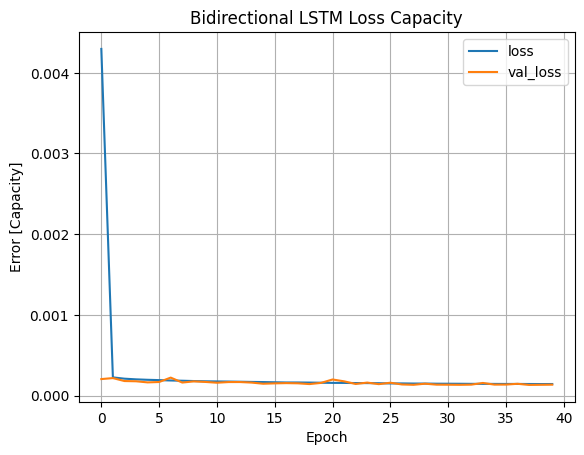

In [21]:
plot_loss(history[-1],'Bidirectional LSTM Loss Capacity')

In [16]:
model_path = os.path.join("models","BiDirRNN_01.keras")

In [23]:
bdrnn_model.save(model_path)

### Performance

### Make Predictions

In [17]:
bdrnn_model = tf.keras.models.load_model(model_path)

In [18]:
test_predictions = bdrnn_model.predict(X_test).flatten()

3675/3675 [==============================] - 12s 3ms/step


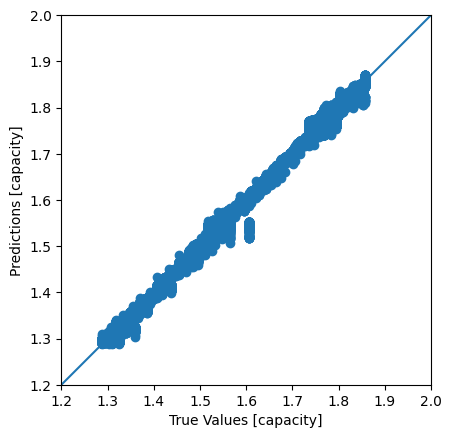

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [capacity]')
plt.ylabel('Predictions [capacity]')
lims = [1.2, 2]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

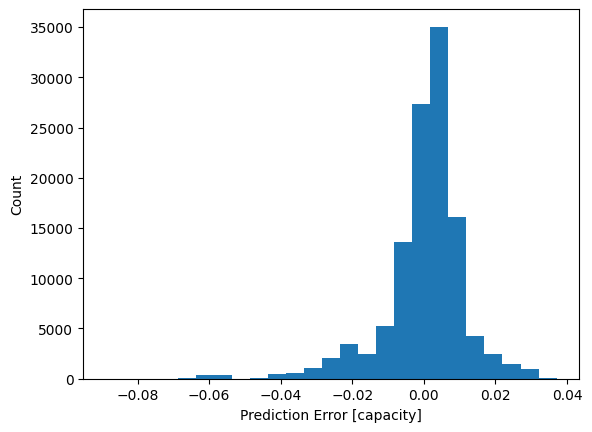

In [ ]:
error = test_predictions - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [capacity]')
_ = plt.ylabel('Count')

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [23]:
# Calculate regression metrics
mse = mean_squared_error(y_test, test_predictions)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.0001346551219314603
Root Mean Squared Error (RMSE): 0.011604099358910209
Mean Absolute Error (MAE): 0.007758778227982675
R-squared (R2): 0.9954407783802051
